In [1]:
#from IPython.display import YouTubeVideo
#YouTubeVideo('ZhLXULFjIjQ', width="1000",height="500")

In [2]:
import pandas as pd
import numpy as np
#from skelearn.preprecessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
import nltk
#from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split

import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack


from sklearn import tree
from sklearn import metrics

import seaborn as sns


import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1. SET 1

####  categorical, numerical features + preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)

In [3]:
data=pd.read_csv('preprocessed_data.csv')

In [4]:
data.head(2)

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   

  clean_categories                 clean_subcategories  \
0     math_science  appliedsciences health_lifescience   
1     specialneeds                        specialneeds   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03

In [5]:
#nltk.download('vader_lexicon')

#### Selecting 70k points

In [6]:
info=data.iloc[:70000,:].copy(deep=True)

In [7]:
info.tail()

school_state teacher_prefix project_grade_category  \
69995           ct             ms             grades_3_5   
69996           in            mrs          grades_prek_2   
69997           nj             ms             grades_6_8   
69998           nc            mrs          grades_prek_2   
69999           ny             ms             grades_6_8   

       teacher_number_of_previously_posted_projects  project_is_approved  \
69995                                             1                    1   
69996                                            21                    1   
69997                                             0                    1   
69998                                            48                    1   
69999                                             3                    1   

                     clean_categories             clean_subcategories  \
69995               literacy_language                        literacy   
69996                      music_arts                      visualarts   
69997  literacy_language math_science  literature_writing mathematics   
69998                 appliedlearning              charactereducation   
69999         math_science music_arts      appliedsciences visualarts   

                                                   essay   price  
69995  my students special eager diverse enthusiastic...  195.34  
69996  i teach 800 kids low socioeconomic urban schoo...  182.98  
69997  the students classroom energetic diverse group...   22.79  
69998  my students come class daily ready work play p...   85.81  
69999  my school opened doors september 2009 the scho...  425.70

In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def polarity_scores(row):
    
    neutral=[]
    negative=[]
    positive=[]
    compound=[]
    for r in row:
        
        scores_dict=sid.polarity_scores(r)
        
        neutral.append(scores_dict['neg'])
        negative.append(scores_dict['neu'])
        positive.append(scores_dict['pos'])
        compound.append(scores_dict['compound'])
    return neutral,positive,negative,compound
    
    
    
    
#neutral,positive,negative,compound=data['essay'][1000:1010].apply(lambda row: polarity_scores(row))
#neutral,positive,negative,compound=polarity_scores(data['essay'][1000:1010])
#neutral,positive,negative,compound=info['essay'].apply(lambda row : polarity_scores(row))
neutral,positive,negative,compound=polarity_scores(info['essay'])

    

In [9]:
info['neutral']=neutral
info['positive']=positive
info['negative']=negative
info['compound']=compound

In [10]:
info.head()

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   
3           ga            mrs          grades_prek_2   
4           wa            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   
3                                             2                    1   
4                                             2                    1   

    clean_categories                 clean_subcategories  \
0       math_science  appliedsciences health_lifescience   
1       specialneeds                        specialneeds   
2  literacy_language                            literacy   
3    appliedlearning                    earlydevelopment   
4  literacy_language                            literacy   

                                               essay   price  neutral  \
0  i fortunate enough use fairy tale stem kits cl...  725.05    0.013   
1  imagine 8 9 years old you third grade classroo...  213.03    0.072   
2  having class 24 students comes diverse learner...  329.00    0.017   
3  i recently read article giving students choice...  481.04    0.030   
4  my students crave challenge eat obstacles brea...   17.74    0.029   

   positive  negative  compound  
0     0.205     0.783    0.9867  
1     0.248     0.680    0.9897  
2     0.262     0.721    0.9860  
3     0.187     0.783    0.9524  
4     0.288     0.683    0.9873

#####  Splitting data

In [11]:
x=info.drop('project_is_approved',1)
y=info['project_is_approved'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,stratify=y)
#x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,train_size=0.8,stratify=y_train)

## 1.1 Vectorizing
### 1.1.1 Tfidf on text data

#### Essay

In [12]:
vectorizer=TfidfVectorizer(min_df=10)

In [13]:
vectorizer.fit(x_train['essay'])
x_tr_essay_tfidf=vectorizer.transform(x_train['essay'])
#x_cv_essay_tfidf=vectorizer.transform(x_cv['essay'])


x_te_essay_tfidf=vectorizer.transform(x_test['essay'])

In [14]:
print('shapes before vectorization')
print(x_train['essay'].shape)
#print(x_cv['essay'].shape)
print(x_test['essay'].shape)

print('='*10,'shape after vectorization','='*10)

print(x_tr_essay_tfidf.shape)
#print(x_cv_essay_tfidf.shape)
print(x_te_essay_tfidf.shape)

shapes before vectorization
(49000,)
(21000,)
========== shape after vectorization ==========
(49000, 12084)
(21000, 12084)


### TF-IDF weighted word2vec

In [15]:
# dict of the vocabulary with words as key and idf values as  there values

"""idf_values=vectorizer.idf_
features=vectorizer.get_feature_names()

word_idf={}
for i in range(len(idf_values)):
    word_idf[features[i]]=idf_values[i]
word_idf"""

tfidf_vect=TfidfVectorizer()
tfidf_vect.fit(x_train['essay']) 
idf_dict=dict(zip(tfidf_vect.get_feature_names(),list(tfidf_vect.idf_)))

#idf_dict['bunyan']

In [16]:
len(idf_dict)

41005

In [17]:
#tfidf_vect.idf_[vectorizer.vocabulary_['00']]
print(len(tfidf_vect.get_feature_names()))
print(len(tfidf_vect.idf_))

41005
41005


In [18]:
from tqdm import tqdm
# function to get TF-IDF weighted word2vec
def get_tfidf_w2v(dictionary,essays,glove_words,tfidf_words):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors
    

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
glove_words = set(model.keys())
tfidf_words=set(tfidf_vect.get_feature_names())


In [19]:
### train data
x_tr_essay=x_train['essay']
tfidf_w2v_vector_train=get_tfidf_w2v(idf_dict,x_tr_essay,glove_words,tfidf_words)

print('lenth of x_train tfidf_weighted w2v vectors = ',len(tfidf_w2v_vector_train))
print('dimensions of the vectors is = ',len(tfidf_w2v_vector_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [01:40<00:00, 485.75it/s]

lenth of x_train tfidf_weighted w2v vectors =  49000
dimensions of the vectors is =  300


In [20]:

###  cv data TF-IDF weighted word2vec
#x_cv_essay=x_cv['essay']
#tfidf_w2v_vectors_cv=get_tfidf_w2v(idf_dict,x_cv_essay,glove_words,tfidf_words)

#print('lenth of x_cv tfidf_weighted w2v vectors = ',len(tfidf_w2v_vectors_cv))
#print('dimensions of the vectors is = ',len(tfidf_w2v_vectors_cv[0]))


In [21]:
# test data TF-IDF weighted word2vec
x_te_essay=x_test['essay']
tfidf_w2v_vectors_test=get_tfidf_w2v(idf_dict,x_te_essay,glove_words,tfidf_words)
print('lenth of x_test tfidf_weighted w2v vectors = ',len(tfidf_w2v_vectors_test))
#print(len(tfidf_w2v_vectors_test[0]))

print('shape of x_train vecs',np.shape(tfidf_w2v_vector_train))
print('shape of x_test vecs',np.shape(tfidf_w2v_vectors_test))
#print('shape of x_cv vecs',np.shape(tfidf_w2v_vectors_cv))

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:45<00:00, 464.77it/s]


lenth of x_test tfidf_weighted w2v vectors =  21000
shape of x_train vecs (49000, 300)
shape of x_test vecs (21000, 300)


In [22]:
### adding tfidf weighted w2v to te datasets
x_train['tfidf_w2v_vector']=tfidf_w2v_vector_train
#x_cv['tfidf_w2v_vector']=tfidf_w2v_vectors_cv
x_test['tfidf_w2v_vector']=tfidf_w2v_vectors_test

### 1.1.2 categorical data

#### school state

In [23]:
cat_vectorizer=CountVectorizer(binary=True)

In [24]:
cat_vectorizer.fit(x_train['school_state'])
x_tr_ss_ohe=cat_vectorizer.transform(x_train['school_state'].values)
#x_cv_ss_ohe=cat_vectorizer.transform(x_cv['school_state'])
x_te_ss_ohe=cat_vectorizer.transform(x_test['school_state'].values)


print('shapes before vectorization')
print(x_train['school_state'].shape)
#print(x_cv['school_state'].shape)
print(x_test['school_state'].shape)
print('='*10,'shape after vectorization','='*10)
print(x_tr_ss_ohe.shape)
#print(x_cv_ss_ohe.shape)
print(x_te_ss_ohe.shape)



shapes before vectorization
(49000,)
(21000,)
========== shape after vectorization ==========
(49000, 51)
(21000, 51)


#### Teacher prefix

In [25]:
nan_rows=info[info.isnull().any(1)]
nan_rows

Empty DataFrame
Columns: [school_state, teacher_prefix, project_grade_category, teacher_number_of_previously_posted_projects, project_is_approved, clean_categories, clean_subcategories, essay, price, neutral, positive, negative, compound]
Index: []

In [26]:
teacher_vect=CountVectorizer(binary=True)

In [27]:
teacher_vect.fit(x_train['teacher_prefix'])
x_tr_pre_ohe=teacher_vect.transform(x_train['teacher_prefix'].values)
#x_cv_pre_ohe=teacher_vect.transform(x_cv['teacher_prefix'])
x_te_pre_ohe=teacher_vect.transform(x_test['teacher_prefix'].values)


print('shapes before vectorization')
print(x_train['teacher_prefix'].shape)
#print(x_cv['teacher_prefix'].shape)
print(x_test['teacher_prefix'].shape)
print('='*10,'shape after vectorization','='*10)
print(x_tr_pre_ohe.shape)
#print(x_cv_pre_ohe.shape)
print(x_te_pre_ohe.shape)

shapes before vectorization
(49000,)
(21000,)
========== shape after vectorization ==========
(49000, 5)
(21000, 5)


#### Project_grde_cat

In [28]:
proj_grade_vect=CountVectorizer(binary=True)

In [29]:
proj_grade_vect.fit(x_train['project_grade_category'])
x_tr_proj_grade_cat_ohe = proj_grade_vect.transform(x_train['project_grade_category'].values)
#x_cv_proj_grade_cat_ohe=proj_grade_vect.transform(x_cv['project_grade_category'])
x_te_proj_grade_cat_ohe = proj_grade_vect.transform(x_test['project_grade_category'].values)


print('shapes before vectorization')
print(x_train['project_grade_category'].shape)
#print(x_cv['project_grade_category'].shape)
print(x_test['project_grade_category'].shape)
print('='*10,'shape after vectorization','='*10)
print(x_tr_proj_grade_cat_ohe.shape)
#print(x_cv_proj_grade_cat_ohe.shape)
print(x_te_proj_grade_cat_ohe.shape)

shapes before vectorization
(49000,)
(21000,)
========== shape after vectorization ==========
(49000, 4)
(21000, 4)


In [30]:
len(info['clean_categories'].unique())

51

#### Clean sub cat

In [31]:
clean_sub_vect=CountVectorizer(binary=True)

In [32]:
clean_sub_vect.fit(x_train['clean_subcategories'])
x_tr_cleansub_ohe=clean_sub_vect.transform(x_train['clean_subcategories'])
#x_cv_cleansub_ohe=clean_sub_vect.transform(x_cv['clean_subcategories'])
x_te_cleansub_ohe=clean_sub_vect.transform(x_test['clean_subcategories'])


print('shapes before vectorization')
print(x_train['clean_subcategories'].shape)
#print(x_cv['clean_subcategories'].shape)
print(x_test['clean_subcategories'].shape)
print('='*10,'shape after vectorization','='*10)
print(x_tr_cleansub_ohe.shape)
#print(x_cv_cleansub_ohe.shape)
print(x_te_cleansub_ohe.shape)

#clean_sub_vect.get_feature_names()

shapes before vectorization
(49000,)
(21000,)
========== shape after vectorization ==========
(49000, 30)
(21000, 30)


#### Clean categories

In [33]:
clean_cat_vect=CountVectorizer(binary=True)

In [34]:
clean_cat_vect.fit(x_train['clean_categories'])
x_tr_cleancat_ohe=clean_cat_vect.transform(x_train['clean_categories'])
#x_cv_cleancat_ohe=clean_cat_vect.transform(x_cv['clean_categories'])
x_te_cleancat_ohe=clean_cat_vect.transform(x_test['clean_categories'])


print('shapes before vectorization')
print(x_train['clean_categories'].shape)
#print(x_cv['clean_categories'].shape)
print(x_test['clean_categories'].shape)
print('='*10,'shape after vectorization','='*10)
print(x_tr_cleancat_ohe.shape)
#print(x_cv_cleancat_ohe.shape)
print(x_te_cleancat_ohe.shape)

#clean_cat_vect.get_feature_names()

shapes before vectorization
(49000,)
(21000,)
========== shape after vectorization ==========
(49000, 9)
(21000, 9)


### 1.1.3 Numerical features

#### price encoding

In [35]:

normalizer=Normalizer()

In [36]:
info['price'].shape

(70000,)

In [37]:
x_tr_price_norm=normalizer.fit_transform(x_train['price'].values.reshape(1,-1))
#x_cv_price_norm=normalizer.fit_transform(x_cv['price'].values.reshape(1,-1))
x_te_price_norm=normalizer.fit_transform(x_test['price'].values.reshape(1,-1))

print('shapes before vectorization')
print(x_train['price'].shape)
#print(x_cv['price'].shape)
print(x_test['price'].shape)
print('='*10,'shape after vectorization','='*10)



x_tr_price_norm=x_tr_price_norm.reshape(-1,1)
#x_cv_price_norm=x_cv_price_norm.reshape(-1,1)
x_te_price_norm=x_te_price_norm.reshape(-1,1)




print(x_tr_price_norm.shape)
#print(x_cv_price_norm.shape)
print(x_te_price_norm.shape)

shapes before vectorization
(49000,)
(21000,)
========== shape after vectorization ==========
(49000, 1)
(21000, 1)


#### Teacher_number_of_previously_posted_projects

In [38]:
x_tr_prevposted_norm=normalizer.fit_transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
#x_cv_prevposted_norm=normalizer.fit_transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_te_prevposted_norm=normalizer.fit_transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print('shapes before vectorization')
print(x_train['teacher_number_of_previously_posted_projects'].shape)
#print(x_cv['teacher_number_of_previously_posted_projects'].shape)
print(x_test['teacher_number_of_previously_posted_projects'].shape)
print('='*10,'shape after vectorization','='*10)


x_tr_prevposted_norm= x_tr_prevposted_norm.reshape(-1,1)
#x_cv_prevposted_norm= x_cv_prevposted_norm.reshape(-1,1)
x_te_prevposted_norm= x_te_prevposted_norm.reshape(-1,1)




print(x_tr_prevposted_norm.shape)
#print(x_cv_prevposted_norm.shape)
print(x_te_prevposted_norm.shape)

shapes before vectorization
(49000,)
(21000,)
========== shape after vectorization ==========
(49000, 1)
(21000, 1)


#### Positive, Neutral, Compund, Negative(Sentiment polarity_scores)

In [39]:
#positive
x_tr_positive_norm=normalizer.fit_transform(x_train['positive'].values.reshape(1,-1))
x_te_positive_norm=normalizer.fit_transform(x_test['positive'].values.reshape(1,-1))

x_tr_positive_norm=x_tr_positive_norm.reshape(-1,1)
x_te_positive_norm=x_te_positive_norm.reshape(-1,1)

#negative
x_tr_negative_norm=normalizer.fit_transform(x_train['negative'].values.reshape(1,-1))
x_te_negative_norm=normalizer.fit_transform(x_test['negative'].values.reshape(1,-1))

x_tr_negative_norm=x_tr_negative_norm.reshape(-1,1)
x_te_negative_norm=x_te_negative_norm.reshape(-1,1)

#neutral

x_tr_neutral_norm = normalizer.fit_transform(x_train['neutral'].values.reshape(1,-1))
x_te_neutral_norm=  normalizer.fit_transform(x_test['neutral'].values.reshape(1,-1))

x_tr_neutral_norm=  x_tr_neutral_norm.reshape(-1,1)
x_te_neutral_norm=   x_te_neutral_norm.reshape(-1,1)

#compound
x_tr_compound_norm=normalizer.fit_transform(x_train['compound'].values.reshape(1,-1))
x_te_compound_norm=normalizer.fit_transform(x_test['compound'].values.reshape(1,-1))

x_tr_compound_norm=x_tr_compound_norm.reshape(-1,1)
x_te_compound_norm=x_te_compound_norm.reshape(-1,1)





# 1.2 Stacking

## 1.2.1 Set 1

In [40]:
info.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'neutral',
       'positive', 'negative', 'compound'],
      dtype='object')

In [41]:
x_tr_set1=hstack((x_tr_essay_tfidf,x_tr_ss_ohe,x_tr_pre_ohe,x_tr_proj_grade_cat_ohe,x_tr_cleansub_ohe,
                  x_tr_cleancat_ohe,x_tr_price_norm,x_tr_prevposted_norm,
                 x_tr_positive_norm,x_tr_negative_norm,x_tr_neutral_norm,
                 x_tr_compound_norm)).tocsr()

In [42]:
#x_cv_set1=hstack((x_cv_essay_tfidf,x_cv_ss_ohe,x_cv_pre_ohe,x_cv_proj_grade_cat_ohe,x_cv_cleansub_ohe,
                  #x_cv_cleancat_ohe,x_cv_price_norm,x_cv_prevposted_norm)).tocsr()

In [43]:
x_te_set1=hstack((x_te_essay_tfidf,x_te_ss_ohe,x_te_pre_ohe,x_te_proj_grade_cat_ohe,x_te_cleansub_ohe,
                  x_te_cleancat_ohe,x_te_price_norm,x_te_prevposted_norm,
                 x_te_positive_norm,x_te_negative_norm,x_te_neutral_norm,
                 x_te_compound_norm)).tocsr()



## Applying Decison Tree

### set 1

In [44]:
#base model without any tuning
clf=DecisionTreeClassifier()


In [45]:
clf.fit(x_tr_set1,y_train)

DecisionTreeClassifier()

In [46]:
y_pred_base_model=clf.predict(x_te_set1)
accuracy=metrics.accuracy_score(y_test,y_pred_base_model)
print('accuracy of the base model is',accuracy)

accuracy of the base model is 0.7531904761904762


In [47]:
clf.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [48]:
## hyp tuning
#max_depth=np.array([1,,3,10,30])
#min_sample_split=np.array([5,10,100,500])
a=[1,3,10,30] #max_depth
b=[5,10,100,500] #min_sample_split

pg={'max_depth':a,'min_samples_split':b}

#tuning_model=GridSearchCV(clf,param_grid=pg,scoring='roc_auc',return_train_score=True,n_jobs=-1)
#tuning_model.fit(x_tr_set1,y_train)
%time tuning_model=GridSearchCV(clf,param_grid=pg,scoring='roc_auc',return_train_score=True,n_jobs=-1,cv=10)
%time tuning_model.fit(x_tr_set1,y_train)

Wall time: 997 µs
Wall time: 7min 32s


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [49]:
tuning_model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [50]:
tuning_model.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=500)

In [51]:
tuning_model.best_score_

0.6424235979092822

In [52]:
#best hyperparameters set1
tuning_model.best_params_

{'max_depth': 10, 'min_samples_split': 500}

In [53]:
tuning_model.cv_results_['mean_train_score']

array([0.56493874, 0.56493874, 0.56493874, 0.56493874, 0.60740987,
       0.60740987, 0.60740987, 0.60740987, 0.70813599, 0.70679229,
       0.70007704, 0.69332735, 0.86921341, 0.86225354, 0.83123193,
       0.78987586])

- best max_depth= 10
- best min_samole_split= 500
- best_auc_score= 0.65000896653717

### heat maps se1

In [54]:
#https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids

#test data
results = pd.DataFrame.from_dict(tuning_model.cv_results_)

max_scores = results.groupby(['param_min_samples_split', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
#sns.heatmap(max_scores.mean_test_score, annot=True,cmap='PiYG')


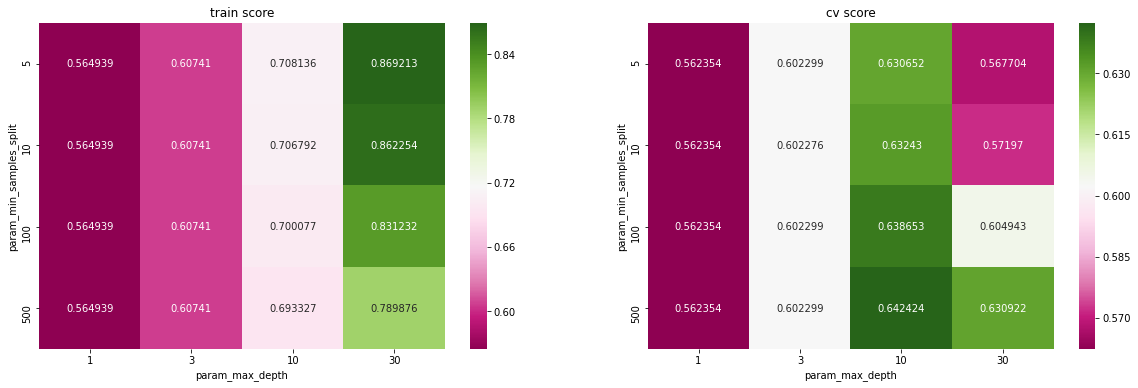

In [55]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
#train score

sns.heatmap(max_scores.mean_train_score,fmt='g',annot=True,cmap="PiYG",ax=ax[0])
#plt.subplot(1,2,figsize=(20,6))
#cv score
sns.heatmap(max_scores.mean_test_score,fmt='g' ,annot=True,cmap='PiYG',ax=ax[1])
ax[0].set_title('train score')
ax[1].set_title('cv score')
plt.show()



### Using best hyperparametrs set1

In [56]:
### using best hypm set1

best_model_set1=DecisionTreeClassifier(max_depth=10,min_samples_split=500)
best_model_set1.fit(x_tr_set1,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=500)

###### Roc auc using predic proba

accuracy of best model on train data in  set1 is  0.8511428571428571
accuracy of best model on test data in  set1 is  0.8336190476190476


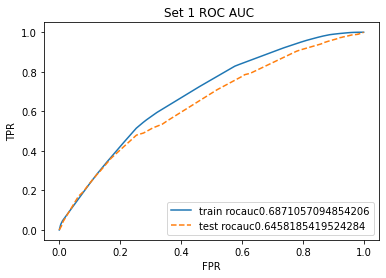

In [57]:
## preducting using best_model_set1 on train data
y_predtrain_set1 = best_model_set1.predict(x_tr_set1)
accuracytrain_set1 = metrics.accuracy_score(y_train,y_predtrain_set1)
print('accuracy of best model on train data in  set1 is ',accuracytrain_set1)

probstrain=best_model_set1.predict_proba(x_tr_set1)

# keeping postive class probs
pos_probtrain_set1=probstrain[:,1]

fprtrain_set1,tprtrain_set1,threshold=metrics.roc_curve(y_train,pos_probtrain_set1)
auctrain_set1=metrics.roc_auc_score(y_train,pos_probtrain_set1)
plt.plot(fprtrain_set1,tprtrain_set1,linestyle='-',label='train rocauc'+str(auctrain_set1))





## preducting using best_model_set1 on test data
y_predtest_set1=best_model_set1.predict(x_te_set1)
accuracy_set1=metrics.accuracy_score(y_test,y_predtest_set1)
print('accuracy of best model on test data in  set1 is ',accuracy_set1)

## calculating auc scores
probstest=best_model_set1.predict_proba(x_te_set1)
# keeping pribs of positive class
pos_probtest_set1=probstest[:,1]

fpr_set1,tpr_set1,threshold_set1=metrics.roc_curve(y_test,pos_probtest_set1)

auctest_set1=metrics.roc_auc_score(y_test,pos_probtest_set1)

plt.plot(fpr_set1,tpr_set1,linestyle='--',label='test rocauc'+str(auctest_set1))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Set 1 ROC AUC ')
plt.show()

#print(metrics.auc(fpr_set1,tpr_set1))
#print(auc_set1)

#### finding best threshold set1

In [58]:
#function returns the best threshold value
def best_threshold(fpr,tpr,threshold):
    
    x=np.argmax(tpr*(1-fpr))
    return threshold[x]


#function to predict y_hat on best threshold value
def pred_on_best_threshold(y_pred_bestmodel,best_thrshold):
    pred=[]
    for y_hat in y_pred_bestmodel:
        if y_hat > best_thrshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred
            

In [59]:
best_threshold_train_set1=best_threshold(fprtrain_set1,tprtrain_set1,threshold)

y_predtrain_best_threshold=pred_on_best_threshold( y_predtrain_set1 ,best_threshold_train_set1)

#len(y_predtrain_best_threshold)



#### Confusion matrix using best threshold
##### set1 train confusion matrix

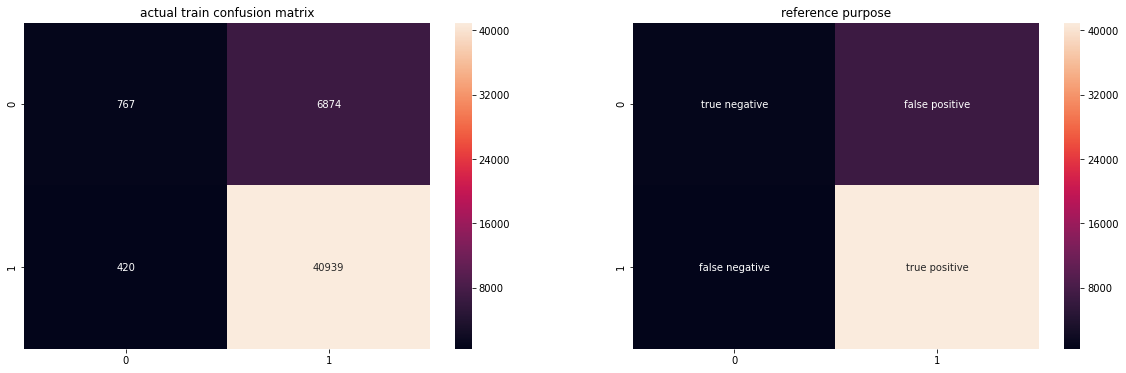

In [60]:
cm_train_set1=metrics.confusion_matrix(y_train,y_predtrain_best_threshold)

fig,ax=plt.subplots(1,2,figsize=(20,6))

#actual confusion matrix
sns.heatmap(cm_train_set1,annot=True,fmt='g',ax=ax[0])



#for reference
labels=['true negative','false positive','false negative','true positive']
labels=np.asarray(labels).reshape(2,2)

ax[0].set_title('actual train confusion matrix')
ax[1].set_title('reference purpose')

sns.heatmap(cm_train_set1,annot=labels,fmt='',ax=ax[1])
plt.show()

In [61]:
#metrics.plot_confusion_matrix(best_model_set1,x_tr_set1,y_train)
#plt.show()

##### set1 test confusion matrix

In [62]:
best_threshold_test_set1=best_threshold(fpr_set1,tpr_set1,threshold_set1)
y_predtest_best_threshold=pred_on_best_threshold( y_predtest_set1 ,best_threshold_test_set1)

#len(y_predtest_best_threshold)

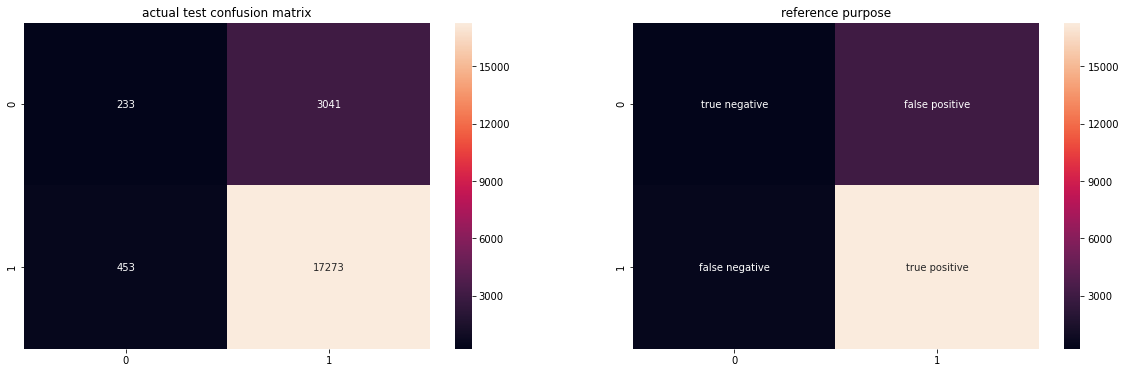

In [63]:
cm_test_set1=metrics.confusion_matrix(y_test,y_predtest_best_threshold)

fig,ax=plt.subplots(1,2,figsize=(20,6))

#actual confusion matrix
sns.heatmap(cm_test_set1,annot=True,fmt='g',ax=ax[0])


#for reference
labels=['true negative','false positive','false negative','true positive']
labels=np.asarray(labels).reshape(2,2)

ax[0].set_title('actual test confusion matrix')
ax[1].set_title('reference purpose')

sns.heatmap(cm_test_set1,annot=labels,fmt='',ax=ax[1])
plt.show()

In [64]:
#metrics.plot_confusion_matrix(best_model_set1,x_te_set1,y_test)

In [65]:
#function to get index of false positive datapoints

def find_false_pos(y,y_hat):
    fp_test_index=[]
    
    for i in range(len(y_test)):
        if y_test[i]==0 and y_predtest_set1[i]==1:
            fp_test_index.append(i)
    return fp_test_index
    


#### Test set1 wordcloud

In [66]:
#gettung index of false positive points
fp_test_index=find_false_pos(y_test,y_predtest_set1)
len(fp_test_index)

3041

In [67]:
#getting false positive datapoints

fp_testdatapts=[]
for i in fp_test_index:
    a=x_test['essay'].values[i]
    fp_testdatapts.append(a)
len(fp_testdatapts)
    

3041

In [68]:
from wordcloud import WordCloud,STOPWORDS

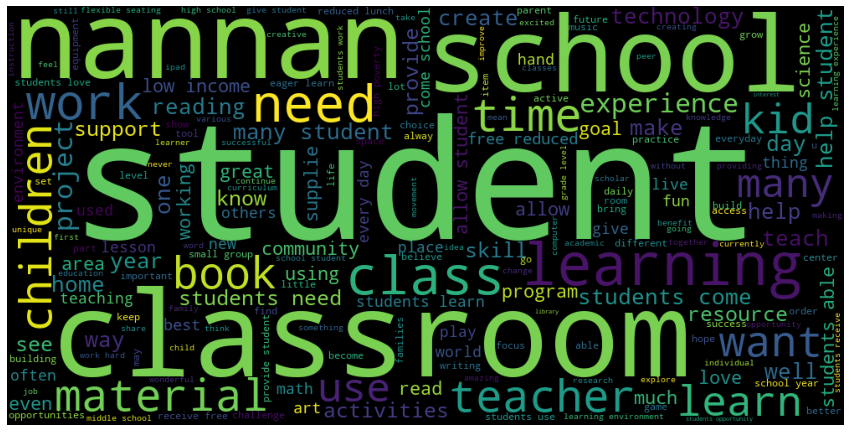

In [69]:
### wordcloud test set1\
#https://stackoverflow.com/questions/45588724/generating-word-cloud-for-items-in-a-list-in-python
plt.figure(figsize=(15,8))
unique=(" ").join(fp_testdatapts)
stopwrds=set(STOPWORDS)

wc=WordCloud(width=1000,height=500,stopwords=stopwrds).generate(unique)
plt.imshow(wc)
plt.axis('Off')
plt.show()

#### box plot fp data points set1 test dataset(price)

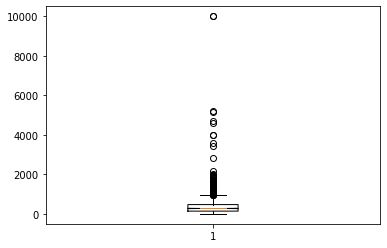

In [70]:
#price
#getting false pos data points
fp_price_datapt=[]
for i in fp_test_index:
    fp_price_datapt.append(x_test['price'].values[i])
len(fp_price_datapt)

#box plot
#plt.figure(figsize=(20,12))
plt.boxplot(fp_price_datapt,fp_testdatapts)
plt.show()

#### PDF of fp data points set1 test dataset(teacher_number_of_previously_posted_projects)

In [71]:
### pdf fp points test set1 teacher prev posted projects
# getting f;ase positive data points in test data

fp_prevposted_datapt=[]
for i in fp_test_index:
    fp_prevposted_datapt.append(x_test['teacher_number_of_previously_posted_projects'].values[i])
len(fp_prevposted_datapt)



3041

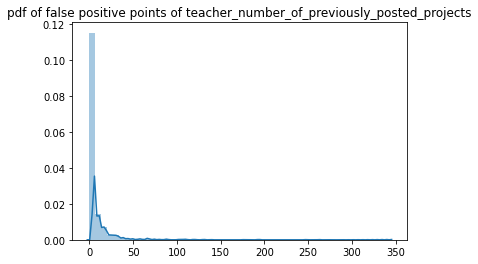

In [72]:
sns.distplot(fp_prevposted_datapt,kde=True)
plt.title('pdf of false positive points of teacher_number_of_previously_posted_projects')
plt.show()

# Stacking
### 1.2.2 Set 2
##### Set 2: categorical, numerical features + preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)

In [73]:
### adding tfidf weighted w2v to te datasets

x_train['tfidf_w2v_vector']=tfidf_w2v_vector_train
#x_cv['tfidf_w2v_vector']=tfidf_w2v_vectors_cv
x_test['tfidf_w2v_vector']=tfidf_w2v_vectors_test

print(np.shape(tfidf_w2v_vector_train))
print(np.shape(tfidf_w2v_vectors_test))
print(np.shape(x_tr_ss_ohe))
print(np.shape(x_tr_pre_ohe))


(49000, 300)
(21000, 300)
(49000, 51)
(49000, 5)


In [74]:
x_tr_set2=hstack((tfidf_w2v_vector_train,x_tr_ss_ohe,x_tr_pre_ohe,x_tr_proj_grade_cat_ohe,x_tr_cleansub_ohe,
                  x_tr_cleancat_ohe,x_tr_price_norm,x_tr_prevposted_norm,
                 x_tr_positive_norm,x_tr_negative_norm,x_tr_neutral_norm,
                 x_tr_compound_norm)).tocsr()

#x_cv_set2=hstack((tfidf_w2v_vectors_cv,x_cv_ss_ohe,x_cv_pre_ohe,x_cv_proj_grade_cat_ohe,x_cv_cleansub_ohe,
                  #x_cv_cleancat_ohe,x_cv_price_norm,x_cv_prevposted_norm)).tocsr()

x_te_set2=hstack((tfidf_w2v_vectors_test,x_te_ss_ohe,x_te_pre_ohe,x_te_proj_grade_cat_ohe,x_te_cleansub_ohe,
                  x_te_cleancat_ohe,x_te_price_norm,x_te_prevposted_norm,
                 x_te_positive_norm,x_te_negative_norm,x_te_neutral_norm,
                 x_te_compound_norm)).tocsr()


print('train=',x_tr_set2.shape,'test= ',x_te_set2.shape)

train= (49000, 405) test=  (21000, 405)


# Applying Decision Tree on set 2

In [75]:
clf_set2=tree.DecisionTreeClassifier()
clf_set2.fit(x_tr_set2,y_train)

DecisionTreeClassifier()

In [76]:
### set 2 hyp tunung

%time tuning_model_set2=GridSearchCV(clf_set2,param_grid=pg,scoring='roc_auc',return_train_score=True,n_jobs=-1)
%time tuning_model_set2.fit(x_tr_set2,y_train)



Wall time: 0 ns
Wall time: 8min 51s


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [77]:
#best hyperparameters set2
tuning_model_set2.best_params_

{'max_depth': 10, 'min_samples_split': 500}

In [78]:
#best auc score set2
tuning_model_set2.best_score_

0.6216089421656141

#### Heatmaps set2

In [79]:
max_scores=pd.DataFrame.from_dict(tuning_model_set2.cv_results_)
max_scores=max_scores.groupby(['param_min_samples_split','param_max_depth']).max()
max_scores=max_scores.unstack()[["mean_test_score","mean_train_score"]]
#max_scores

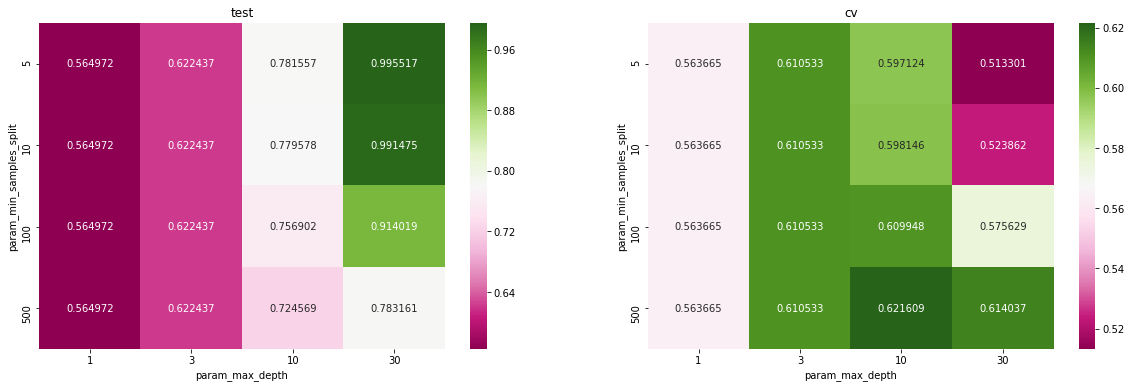

In [80]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
sns.heatmap(max_scores['mean_train_score'],annot=True,cmap='PiYG',fmt='g',ax=ax[0])
sns.heatmap(max_scores['mean_test_score'],annot=True,cmap='PiYG',fmt='g',ax=ax[1])

ax[0].set_title('test')
ax[1].set_title('cv')

plt.show()


#### Using best hyperparameters set2

In [81]:
## using best hypm set2
best_model_set2=tree.DecisionTreeClassifier(max_depth=10,min_samples_split=500)
best_model_set2.fit(x_tr_set2,y_train)


DecisionTreeClassifier(max_depth=10, min_samples_split=500)

In [82]:
y_pred_set2=best_model_set2.predict(x_te_set2)

In [83]:
accuracy=metrics.accuracy_score(y_test,y_pred_set2)
accuracy

0.835

##### ROc auc curve using predict proba

accuracy of best model on train data in  set2 is  0.847469387755102
auc score of set2 train data is  0.7252927758339862
accuracy of best model on test data in  set2 is  0.835
auc roc score of set2 on testr data is  0.6326913945816488


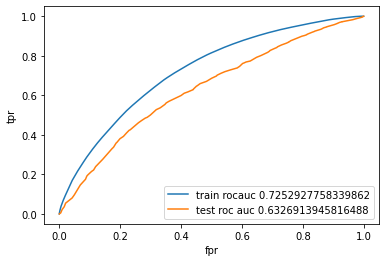

In [84]:
#train_data

y_predtrain_set2 = best_model_set2.predict(x_tr_set2)
accuracytrain_set2 = metrics.accuracy_score(y_train,y_predtrain_set2)
print('accuracy of best model on train data in  set2 is ',accuracytrain_set2)

probstrain = best_model_set2.predict_proba(x_tr_set2)

# keeping postive class probs
pos_probtrain_set2 = probstrain[:,1]

fprtrain_set2,tprtrain_set2,threshold=metrics.roc_curve(y_train,pos_probtrain_set2)
auctrain_set2=metrics.roc_auc_score(y_train,pos_probtrain_set2)
print('auc score of set2 train data is ',auctrain_set2)
plt.plot(fprtrain_set2,tprtrain_set2,linestyle='-',label='train rocauc '+str(auctrain_set2))



#test data
y_predtest_set2=best_model_set2.predict(x_te_set2)
accuracytest_set2=metrics.accuracy_score(y_test,y_predtest_set2)
print('accuracy of best model on test data in  set2 is ',accuracytest_set2)

probstest_set2=best_model_set2.predict_proba(x_te_set2)
#Probabilities for the positive outcome is kept

pos_testprob_set2=probstest_set2[:,1]
testauc_roc_score_set2=metrics.roc_auc_score(y_test,pos_testprob_set2)
print('auc roc score of set2 on testr data is ',testauc_roc_score_set2)
fprtest_set1,tprtest_set1,threshold=metrics.roc_curve(y_test,pos_testprob_set2)

plt.plot(fprtest_set1,tprtest_set1,label='test roc auc ' +str(testauc_roc_score_set2))



plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.show()

#### Finding best threshold
##### Set2 train data

In [85]:
train_set2best_threshold=best_threshold(fprtrain_set2,tprtrain_set2,threshold)
print('best threshold for training data set2 is',train_set2best_threshold)

# y_hat 
ytrain_hat_best_threshold=pred_on_best_threshold(y_predtrain_set2,train_set2best_threshold)
print(len(ytrain_hat_best_threshold))


best threshold for training data set2 is 0.8515981735159818
49000


In [86]:
#metrics.plot_confusion_matrix(best_model_set2,x_tr_set2,y_train)
#plt.show()

In [87]:
#### confusion matrix on best threshold value
cm=metrics.confusion_matrix(y_train,ytrain_hat_best_threshold)

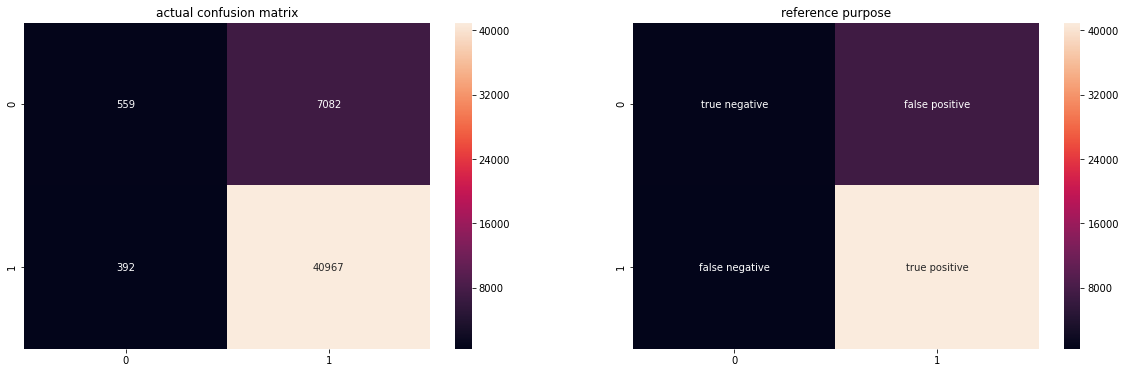

In [88]:
fig,ax=plt.subplots(1,2,figsize=(20,6))

#actual confusion matrix
sns.heatmap(cm,annot=True,fmt='g',ax=ax[0])



#for reference
labels=['true negative','false positive','false negative','true positive']
labels=np.asarray(labels).reshape(2,2)

ax[0].set_title('actual confusion matrix')
ax[1].set_title('reference purpose')

sns.heatmap(cm,annot=labels,fmt='',ax=ax[1])
plt.show()

#### confusion matrix of test data

In [89]:
#metrics.plot_confusion_matrix(best_model_set2,x_te_set2,y_test)
#plt.show()

In [90]:
test_set2best_threshold=best_threshold(fprtest_set1,tprtest_set1,threshold)
print('best threshold for training data set2 is',train_set2best_threshold)

# y_hat 
ytest_hat_best_threshold=pred_on_best_threshold(y_predtest_set2,test_set2best_threshold)
print(len(ytest_hat_best_threshold))


best threshold for training data set2 is 0.8515981735159818
21000


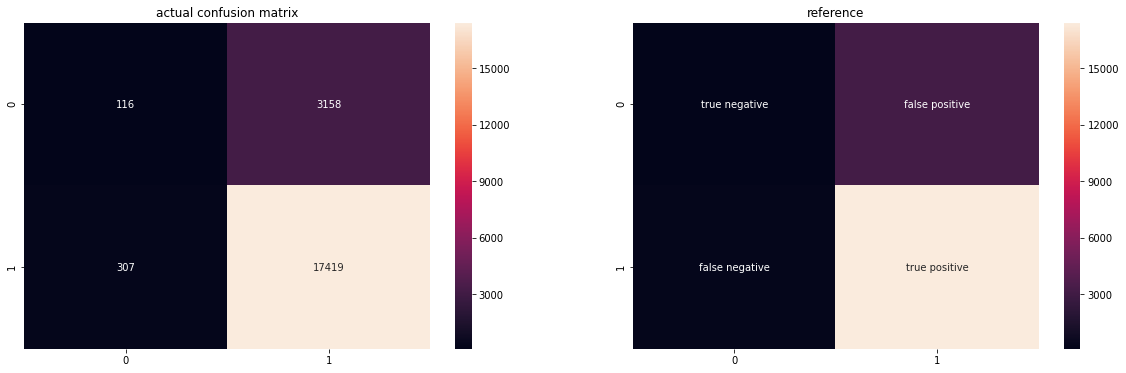

In [91]:
#### confusionmaytrix set2 test data
cm=metrics.confusion_matrix(y_test,ytest_hat_best_threshold)

fig,ax=plt.subplots(1,2,figsize=(20,6))

sns.heatmap(cm,annot=True,fmt='g',ax=ax[0])

labels=['true negative','false positive','false negative','true positive']
labels=np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot=labels,fmt='',ax=ax[1])

ax[0].set_title('actual confusion matrix')
ax[1].set_title('reference')

plt.show()

#### false positive points of test data set2

In [92]:
fp_index_test_set2=find_false_pos(y_test,y_predtest_set2)
len(fp_index_test_set2) #no of false positive points

3041

In [93]:
### fp data points of essay
fp_datapts_essay_set2=[]
for i in fp_index_test_set2:
    fp_datapts_essay_set2.append(x_test['essay'].values[i])
len(fp_datapts_essay_set2)
#print(fp_datapts_essay_set2)  

3041

#### set2 test data essay wordcloud

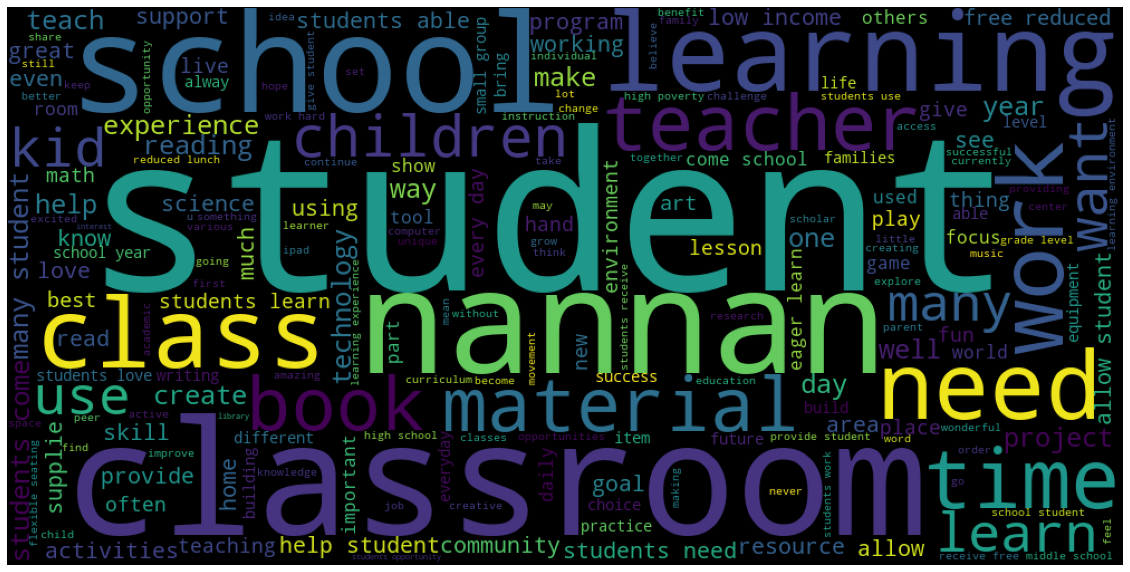

In [94]:
# word cloud of essay false data points
plt.figure(figsize=(20,12))
unique_string=(" ").join(fp_datapts_essay_set2)
wc=WordCloud(width=1000,height=500).generate(unique_string)
plt.imshow(wc)
plt.axis('Off')
plt.show()


#### pdf of false positive points of pdf of teacher_number_of_previously_posted_projects

In [95]:
# fp data points of teacher_number_of_previously_posted_projects
fp_datapts_prevposted_set2=[]
for i in fp_index_test_set2:
    fp_datapts_prevposted_set2.append(x_test['teacher_number_of_previously_posted_projects'].values[i])
len(fp_datapts_prevposted_set2) 

3041

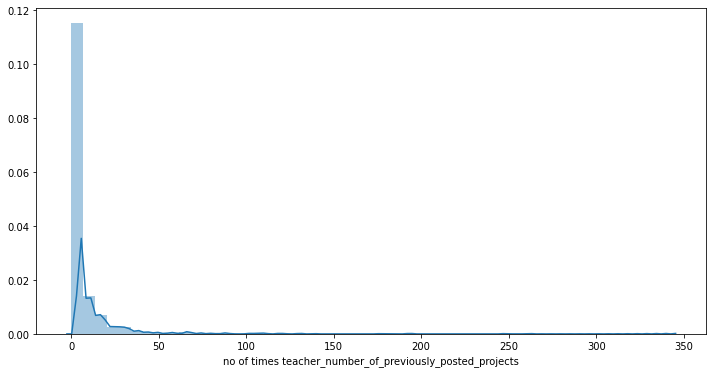

In [96]:
plt.figure(figsize=(12,6))
sns.distplot(fp_datapts_prevposted_set2,kde=True)
plt.xlabel('no of times teacher_number_of_previously_posted_projects')
plt.show()

## Observations

- Essays having words like classrooms,students,school,time,community etc were actually accepted but predicted to be rejected by the model 
- model predicted that most number of projects are accepted when no of times teacher_number_of_previously_posted_projects is between 0 to 15 approximately

### Note
- Since almost each of the review contains words like classrooms,students,school, etc, it can not be said very confidently that using these words will result in the acceptance or the rejection of the request

# 2. Task 2

In [97]:
dt_task2 = DecisionTreeClassifier()
dt_task2.fit(x_tr_set1,y_train)

DecisionTreeClassifier()

In [98]:
feature_impo=dt_task2.feature_importances_
print('len of feature_importance list =  ', len(feature_impo))

#keeping only non zero feature importance ones

non_zere_feat_impo=[f for f in feature_impo if f>0]
print('no of non zero feature importance values is = ',len(non_zere_feat_impo))

non_zero_fi_lenth=len(non_zere_feat_impo)
#print(non_zero_fi_lenth)

len of feature_importance list =   12189
no of non zero feature importance values is =  2510


In [99]:
#index=np.argsort(non_zere_feat_impo)[::-1][:non_zero_fi_lenth]
#len(index)

#non_zero_feat_datapts=np.take(non_zere_feat_impo , index )
#print(len(non_zero_feat_datapts))
#print(non_zero_feat_datapts)#data pts having non zero feature importance


In [100]:
def values(x,len_non_zero_fi):
    return x[:,dt_task2.feature_importances_.argsort()[::-1][:len_non_zero_fi]]
    

In [101]:
#d_ features out of d features
x_train_non_zero=values(x_tr_set1,non_zero_fi_lenth)
x_test_non_zero=values(x_te_set1,non_zero_fi_lenth)

#print(len(x_train_non_zero.shape))
#print(len(x_test_non_zero.shape))
#TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]


print(x_train_non_zero.shape)
print(x_test_non_zero.shape)

(49000, 2510)
(21000, 2510)


### applying linera svm on d_ features

In [102]:
from sklearn.svm import LinearSVC

In [103]:
#a=[1,2,4,6,4,7,8,5,7,5,33,64,5,4446,554,6654,65,765,765,643,645,]
#b=[i for i in a if i>200]
#b#non zereos features values
#z=len(b)
#print(b)
#print(z)
#x=np.argsort(a)[::-1][:7]
#np.take(a,x)

In [104]:
linsvm_clf = LinearSVC()

In [105]:
linsvm_clf.fit(x_train_non_zero,y_train)

LinearSVC()

In [106]:
linsvm_clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [107]:


pm={'penalty':['l2','l1'],
    'C':[1, 10, 100, 1000],
   }

In [108]:
%time tuning_model=GridSearchCV(linsvm_clf,param_grid=pm,return_train_score=True,cv=10,verbose=1,scoring='roc_auc',n_jobs=-1)
%time tuning_model.fit(x_tr_set1,y_train)

Wall time: 0 ns
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Wall time: 4min 20s


GridSearchCV(cv=10, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [109]:
tuning_model.best_params_

{'C': 1, 'penalty': 'l2'}

In [110]:
df=pd.DataFrame.from_dict(tuning_model.cv_results_ )
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'split5_train_score',
       'split6_train_score', 'split7_train_score', 'split8_train_score',
       'split9_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [111]:
### heatmaps

max_scores=df.groupby(['param_C','param_penalty']).max()
max_scores=max_scores.unstack()[['mean_train_score','mean_test_score']]
max_scores

mean_train_score           mean_test_score          
param_penalty               l1        l2              l1        l2
param_C                                                           
1                          NaN  0.901508             NaN  0.680449
10                         NaN  0.940512             NaN  0.645139
100                        NaN  0.942190             NaN  0.618704
1000                       NaN  0.920708             NaN  0.613852

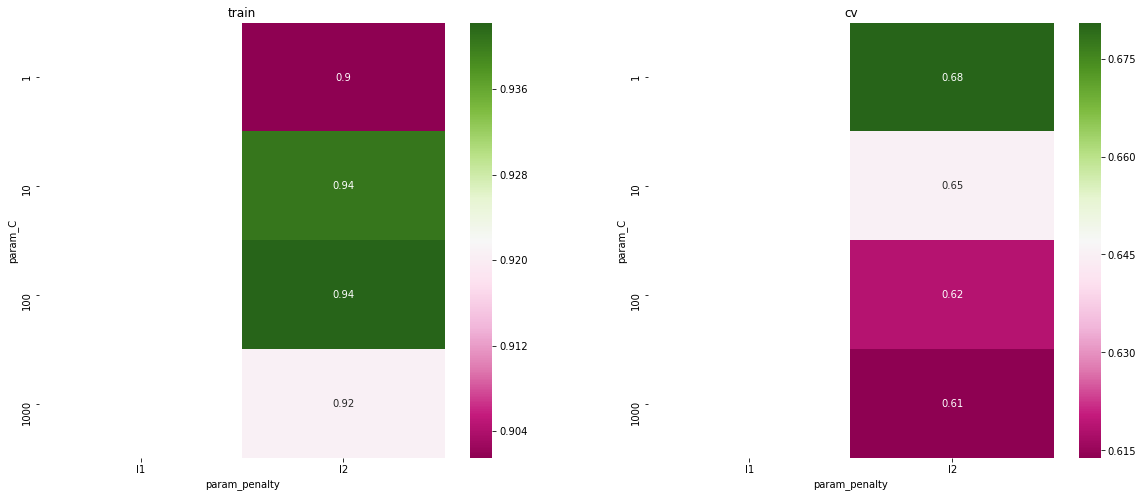

In [112]:
fig,ax=plt.subplots(1,2,figsize=(20,8))
sns.heatmap(max_scores['mean_train_score'],annot=True,cmap='PiYG',ax=ax[0])

sns.heatmap(max_scores['mean_test_score'],annot=True,cmap='PiYG',ax=ax[1])

ax[0].set_title('train')
ax[1].set_title('cv')
plt.show()


In [113]:
#roc auc

print('best auc score of the model = ',tuning_model.best_score_)
print('best parameters = ',tuning_model.best_params_)
print('best estimator = ',tuning_model.best_estimator_)

best auc score of the model =  0.6804494763620407
best parameters =  {'C': 1, 'penalty': 'l2'}
best estimator =  LinearSVC(C=1)


In [114]:
#### using best hyperparameters
best_model_non_zero=LinearSVC(C=1,penalty='l2')
best_model_non_zero.fit(x_train_non_zero,y_train)

LinearSVC(C=1)

In [115]:
y_pred_train_nonzero = best_model_non_zero.predict(x_train_non_zero)
y_pred_nonzero=best_model_non_zero.predict(x_test_non_zero)

In [116]:
accuracy_train_nonzero=metrics.accuracy_score(y_train,y_pred_train_nonzero)
print('accuracy of the best model on train data is is ',accuracy_train_nonzero)

accuracy_nonzero=metrics.accuracy_score(y_test,y_pred_nonzero)
print('accuracy of the best model on test data is is ',accuracy_nonzero)

accuracy of the best model on train data is is  0.8480204081632653
accuracy of the best model on test data is is  0.8445238095238096


In [117]:
# using calibrated model since linear svc dont have predic proba or dosent return probabilitis

#https://stackoverflow.com/questions/54402210/how-to-enable-probability-estimates-when-using-scikitlearns-linearsvc-classifie
from sklearn.calibration import CalibratedClassifierCV
# using lin svc wuth best hyperparameters inside calibration model

cali_model=CalibratedClassifierCV(LinearSVC(C=1,penalty='l2'),cv=10,n_jobs=-1)

In [118]:
cali_model.fit(x_train_non_zero,y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1), cv=10, n_jobs=-1)

In [119]:
#train data accuracy
y_pred_train_calib_model=cali_model.predict(x_train_non_zero)
print('accuracy of calibrated model on train data is',metrics.accuracy_score(y_train,y_pred_train_calib_model))

accuracy of calibrated model on train data is 0.8466938775510204


In [120]:
#test data
y_pred_calib=cali_model.predict(x_test_non_zero)
print('accuracy of the calibrated model on test data is ',metrics.accuracy_score(y_test,y_pred_calib))

accuracy of the calibrated model on test data is  0.844047619047619


- accuracy of the original linar svc model and the calibrateed model on train and test data are almost equal
- linear svc accuracy train and test are  =       0.8487959183673469 and  0.8440952380952381 respectively
- calibrated model accuracy train and test are =  0.8475510204081632 and  0.8445238095238096 respectively

In [121]:
probtrain_calib=cali_model.predict_proba(x_train_non_zero)
probtest_calib = cali_model.predict_proba(x_test_non_zero)

# keeping probs of positive class for both train and test data


In [122]:
#test data
positive_train = probtrain_calib[:,1]
#train data
positive_test = probtest_calib[:,1]

In [123]:
fpr,tpr,threshold=metrics.roc_curve(y_train,positive_train)

fpr_test,tpr_test,threshold_test=metrics.roc_curve(y_test,positive_test)

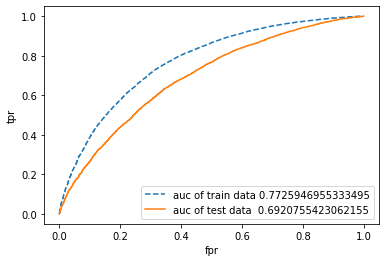

In [124]:
#train
plt.plot(fpr,tpr,linestyle='--',label='auc of train data '+str(metrics.auc(fpr,tpr)))
#test
plt.plot(fpr_test,tpr_test,linestyle='-',label='auc of test data  '+str(metrics.auc(fpr_test,tpr_test)))

plt.xlabel('fpr')
plt.ylabel('tpr')

plt.legend()
plt.show()

In [125]:
#best threshold
def best_threshold(fpr,tpr,thres):
    x=np.argmax(tpr*(1-fpr))
    return thres[x]

In [126]:
#train best threshold
train_best_thres=best_threshold(fpr,tpr,threshold)
print('best threshold for trin set is ',train_best_thres)

#test best thres
test_best_thres=best_threshold(fpr_test,tpr_test,threshold_test)
print('best threshold for test data is ',test_best_thres)


best threshold for trin set is  0.828237211056552
best threshold for test data is  0.8427197903203953


In [127]:
# predictions using best threshold

#train
y_predtrain_bestthres=pred_on_best_threshold(y_pred_train_calib_model,train_best_thres)

#test
y_predtest_bestthres = pred_on_best_threshold(y_pred_calib ,test_best_thres)

### confusion matrix on best threshold

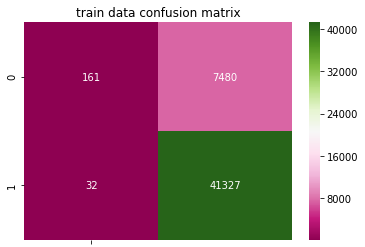

In [128]:
#train
cm=metrics.confusion_matrix(y_train,y_predtrain_bestthres)
sns.heatmap(cm,annot=True,fmt='g',cmap="PiYG",xticklabels=[''])
plt.title('train data confusion matrix')
plt.plot()
plt.show()


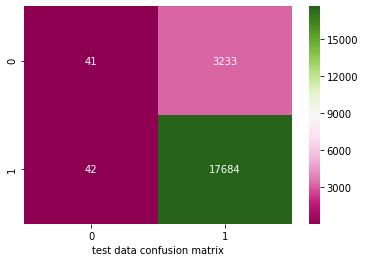

In [129]:
# test data 
cm=metrics.confusion_matrix(y_test,y_predtest_bestthres)
sns.heatmap(cm,annot=True,cmap="PiYG",fmt='g')
plt.xlabel('test data confusion matrix')
plt.plot()
plt.show()

In [130]:
#test
fp_test_index=find_false_pos(y_test,y_predtest_bestthres)
print(len(fp_test_index))

fp_test_datapt=[]
for i in fp_test_index:
    fp_test_datapt.append(x_test['essay'].values[i])
    
#print(len(fp_test_datapt))

3041


In [131]:
fp_test_datapt[:1]

['my students best city they curious thoughtful love exploring new ideas they self motivated always ready discover new things my students articulate amazing conversations class i teach title i school new york students receive free breakfast lunch despite hardships face home students always eager learn world live over last twenty three years working inner city school i seen asthma allergies affect lives students one thing help alleviate asthma epidemic schools stop using chalk it become almost impossible find good dustless chalk and even find although chalk says dustless still leaves behind messy dusty residue having wall mounted dry erase board would take one thing long list things students parents worry nannan']

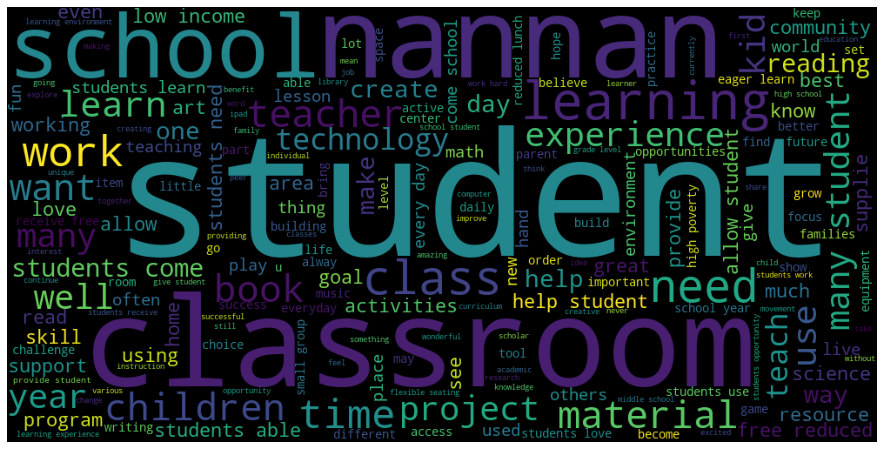

In [132]:
## wordcloud
stopwrds=set(STOPWORDS)
plt.figure(figsize=(20,8))
unique_strings=(" ").join(fp_test_datapt)
wc=WordCloud(width=1000,height=500,stopwords=stopwrds).generate(unique_strings)
plt.imshow(wc)
plt.axis("Off")
plt.plot()
plt.show()

#### boxplot (price) on false positive data points


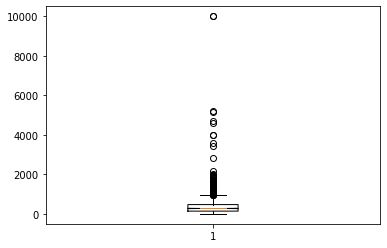

In [133]:
fp_testprice_datapt=[]
for i in fp_test_index:
    fp_testprice_datapt.append(x_test['price'].values[i])

#box plot

plt.boxplot(fp_testprice_datapt,fp_test_datapt)
plt.plot()
plt.show()

#### pdf tacher number of previously posted projects

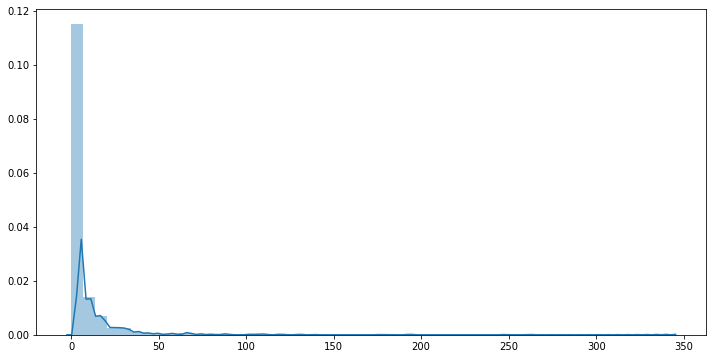

In [134]:
plt.figure(figsize=(12,6))

fp_testprevposted_datapt=[]
for i in fp_test_index:
    fp_testprevposted_datapt.append(x_test['teacher_number_of_previously_posted_projects'].values[i])

sns.distplot(fp_testprevposted_datapt,kde=True)
plt.plot()
plt.show()

## Observations

- Essays having words like classrooms,students,school,learning,experience etc were actually accepted but predicted to be rejected by the model 
- model predicted that most number of projects are accepted when no of times teacher_number_of_previously_posted_projects is between 1 to 15 approximately

### Note
- Since almost each of the review contains words like classrooms,students,school, etc, it can not be said very confidently that using these words will result in the acceptance or the rejection of the request

# Summary

In [135]:
from prettytable import PrettyTable

In [136]:
table=PrettyTable()

In [137]:
table.field_names =['Vectorizer','Model','Hyper parameter','AUC']

In [141]:
table.add_row(['TFIDF','Decision Tree','max_depth=10, min_samples_split=500 ','0.6424235979092822'])
table.add_row(['TFIDF W2VEC','Decision Tree','max_depth=10, min_samples_split=500 ','0.6216089421656141'])


In [139]:
print(table)

+-------------+---------------+--------------------------------------+--------------------+
|  Vectorizer |     Model     |           Hyper parameter            |        AUC         |
+-------------+---------------+--------------------------------------+--------------------+
|    TFIDF    | Decision Tree | max_depth=10, min_samples_split=500  | 0.6440973839711586 |
| TFIDF W2VEC | Decision Tree | max_depth=10, min_samples_split=500  | 0.620748802811731  |
+-------------+---------------+--------------------------------------+--------------------+
